# Bookmark Clustering

## Import Packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
import seaborn as sns
from time import time
import matplotlib.pyplot as plt 
%matplotlib inline

review (Galvanize) topic modeling - NMF etc.

In [2]:
df = pd.read_pickle('Data/df_website_content.pkl')

In [3]:
df = df.drop_duplicates()

In [4]:
df = df[df['text'] != 'empty']

In [5]:
df = df.sample(frac=1)

In [6]:
df.reset_index(drop=True, inplace=True)

## K-Means

The goal here is to try and determine how many topics to use for the other clustering algorithms

Sklearn KMeans centers the data but doing normalization explicitly here 

In [23]:
tf_idf_vectorizer = TfidfVectorizer(stop_words='english', min_df=2, max_df=.95)
tf_idf = tf_idf_vectorizer.fit_transform(df['text'])

In [8]:
tf_idf = normalize(tf_idf)

In [9]:
def build_models(data, cluster_lst, n_iter, jobs=4):
    model_dict = {}
    for k in cluster_lst:
        model_dict[k] = {}
        model = KMeans(n_clusters=k, n_init=n_iter, n_jobs=jobs, random_state=123)
        model_dict[k]['model'] = model
        model_dict[k]['distances'] = model.fit_transform(tf_idf)
    return model_dict

In [10]:
k_lst = np.arange(5, 120, 20)

In [11]:
start = time()
models_dict = build_models(tf_idf, k_lst, 15, 4)
end = time()
print end - start

210.365999937


In [12]:
h_lst = [abs(models_dict[k]['model'].score(tf_idf)) for k in k_lst]

In [13]:
def plot_k_vs_heterogeneity(k_values, heterogeneity_values):
    plt.figure(figsize=(7,4))
    plt.plot(k_values, heterogeneity_values, linewidth=4)
    plt.xlabel('K')
    plt.ylabel('Heterogeneity')
    plt.title('K vs. Heterogeneity')
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

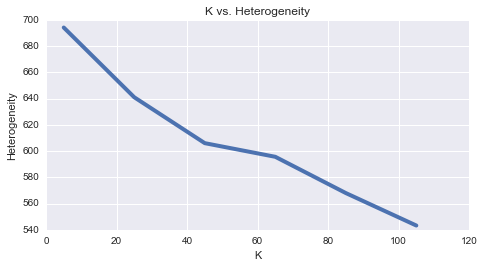

In [14]:
plot_k_vs_heterogeneity(k_lst, h_lst)

In [15]:
def print_bin_counts(models, cluster_lst):
    for k in cluster_lst:
        print "bin count of cluster {0}:".format(k)
        np.bincount(models[k]['model'].labels_)

Build a function to plot bincounts for a particular cluster count k

In [16]:
def plt_cluster_counts(k_val, models, ticks=True, logscale=False):
    labels = models[k_val]['model'].labels_
    g = sns.barplot(x=np.arange(k_val), y=np.bincount(labels))
    if not ticks:
        g.set(xticklabels=[])
    if logscale:
        g.figure.get_axes()[0].set_yscale('log')
    else: plt.show()

Most of the bookmarks are data science, pure math, or finance.  Three major cluster groups make sense in this context.

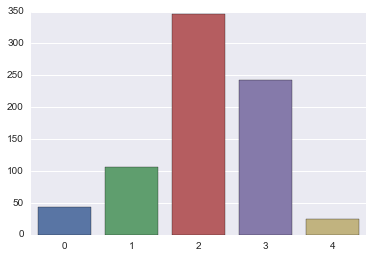

In [17]:
plt_cluster_counts(5, models_dict)

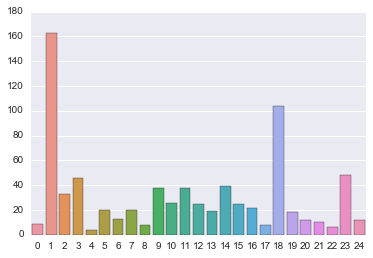

In [18]:
plt_cluster_counts(25, models_dict)

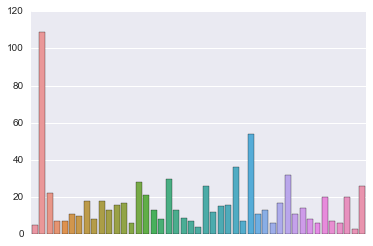

In [19]:
plt_cluster_counts(45, models_dict, ticks=False)

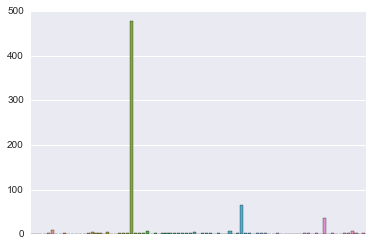

In [125]:
plt_cluster_counts(85, models_dict, ticks=False)

In [25]:
indx_to_word = {v:k for k,v in tf_idf_vectorizer.vocabulary_.iteritems()}

In [269]:
def print_cluster_words(df, models, word_map, k, n_words, n_docs=5, display_content=False):
    #should check if k is valid
    centroids = models[k]['model'].cluster_centers_
    for c in xrange(len(centroids)):
        print('Cluster {0:d}    '.format(c)),
        indx = centroids[c].argsort()[::-1]
        for i in xrange(n_words):
            print('{0:s}:{1:.3f}'.format(word_map[indx[i]], centroids[c, indx[i]])),
        print('')
        
        if display_content:
            c_filter = models_dict[k]['model'].labels_ == c
            min_cluster_idx = models_dict[k]['distances'][c_filter][:,c].argsort()
            cluster_df = df['text'][c_filter]
            cluster_df.reset_index(drop=True, inplace=True)
            nearest_txt_df = cluster_df.iloc[min_cluster_idx]
       
            if len(cluster_df) >= n_docs:
                for i in xrange(n_docs):
                    text = ' '.join(nearest_txt_df.iloc[i].split(None, 25)[0:25]).encode('utf-8')
                    print('\n* {0:s}\n  {1:s}'.format(
                            text[:90], text[90:200] if len(text) > 90 else ''))
            else: print("not enough docs in group")
        print('==========================================================')

In [284]:
print_cluster_words(df, models_dict, word_map=indx_to_word, k=25, n_words=6)

Cluster 0     theorem:0.205 integral:0.087 vector:0.085 equations:0.074 qed:0.070 integrals:0.068 
Cluster 1     data:0.073 learning:0.032 science:0.029 amp:0.024 python:0.023 learn:0.020 
Cluster 2     forex:0.260 trading:0.204 currency:0.087 market:0.083 trade:0.061 strategy:0.048 
Cluster 3     ago:0.325 days:0.291 com:0.051 like:0.048 just:0.043 comments:0.042 
Cluster 4     characters:0.396 affiliates:0.266 sure:0.261 image:0.259 accepting:0.249 robot:0.240 
Cluster 5     neural:0.159 network:0.123 networks:0.093 memory:0.080 output:0.079 layer:0.078 
Cluster 6     time:0.092 model:0.092 data:0.085 team:0.072 series:0.053 gmt:0.048 
Cluster 7     mathematica:0.144 stack:0.131 vote:0.091 overflow:0.074 answer:0.073 answers:0.072 
Cluster 8     frac:0.211 theta:0.145 x_:0.101 gradient:0.082 sin:0.068 displaystyle:0.065 
Cluster 9     haskell:0.099 theory:0.088 monad:0.070 type:0.061 monads:0.058 book:0.054 
Cluster 10     algorithm:0.072 array:0.054 algorithms:0.039 number:0.036 pro

In [270]:
print_cluster_words(df, models_dict, indx_to_word, 45, 6, display_content=True)

Cluster 0     theorem:0.326 integral:0.130 qed:0.125 integrals:0.122 calculus:0.096 derivative:0.092 

* # Adventures in Analysis A place for proofs, examples, and topics I find interesting. Skip
   to content * Home * About ## Mollification and the

* | Theorem of the Day | | ---|---|---|--- | Home Resources Centre Gallery Shop Visitors' Bo
  ok Acknowledgements | Other listings --- Alphabetical Theorem List Subject

* * Skip to navigation (Press Enter) * Skip to main content (Press Enter) * Home * Threads *
   Index * About * # Math Insight

* Menu * Home * Articles * Calculus Guide * Contact * About * Newsletter * Blog * Feedback #
   Intuition Cheatsheet ### Math is no

* # User:LucasVB/Gallery From Wikipedia, the free encyclopedia &lt; User:LucasVB Jump to: na
  vigation, search — Main | Talk | Junk | Gallery | Sandbox — ---
Cluster 1     data:0.087 science:0.039 learning:0.039 amp:0.026 python:0.026 learn:0.025 

* Piotr Migdał - blog Projects Articles Publications Resume About P

With a cluster count of 45, many of the cluster are pure in content.  However, there are some cluster which have similar content but are split into different clusters.

## LDA

Not all topics have a clear theme
Things to try:
try setting max_features in cv (this seemed to help)
use graphlab
modify alpha and beta in LDA
reduce the number of topics
*there was something about using k-means (elbow plot to initalize other algos)

In [ ]:
cv = CountVectorizer(stop_words='english', min_df=2, max_df=.95)

In [ ]:
cv2 = CountVectorizer(stop_words='english', min_df=2, max_df=.95, max_features=10000)

In [ ]:
cv3 = CountVectorizer(stop_words='english', min_df=2, max_df=.95, max_features=5000)

In [ ]:
tf = cv.fit_transform(df['text'])

In [ ]:
tf2 = cv2.fit_transform(df['text'])

In [ ]:
tf3 = cv3.fit_transform(df['text'])

In [ ]:
len(cv.get_feature_names())

In [ ]:
len(cv2.get_feature_names())

In [ ]:
lda_1 = LatentDirichletAllocation(n_topics=30, max_iter=100, n_jobs=4, doc_topic_prior=5.0, topic_word_prior=None, random_state=0)

In [ ]:
lda_2 = LatentDirichletAllocation(n_topics=30, max_iter=100, n_jobs=4, doc_topic_prior=5.0, topic_word_prior=None, random_state=0)

In [ ]:
lda_3 = LatentDirichletAllocation(n_topics=30, max_iter=100, n_jobs=4, doc_topic_prior=5.0, topic_word_prior=None, random_state=0)

In [ ]:
t0 = time()
lda_1.fit(tf)
print "done in {0}".format(time()-t0)

In [ ]:
t0 = time()
lda_2.fit(tf2)
print "done in {0}".format(time()-t0)

In [ ]:
t0 = time()
lda_3.fit(tf3)
print "done in {0}".format(time()-t0)

In [ ]:
lda_2.components_[0]

In [ ]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print "Topic #%d:" % topic_idx
        print " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

In [ ]:
print_top_words(lda_1, cv.get_feature_names(), 20)

In [ ]:
print_top_words(lda_2, cv2.get_feature_names(), 20)

In [ ]:
print_top_words(lda_3, cv3.get_feature_names(), 20)

Try using graplab

In [ ]:
lda_2.transform(tf2)[0]

## Code Archive